In [188]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
page = requests.get("http://www.angelfire.com/wa/adf/101.html")

In [152]:
soup = BeautifulSoup(page.content, 'html.parser')
script = soup.body.findAll('p')

In [153]:
script = [re.sub('[\r\n\xa0]', '', x.text) for x in script]
script = [re.sub('(\s\s)+', ' ', x).strip() for x in script]

In [157]:
dialogue = [1 if re.match('[A-Z][a-z]+ - ', x) else 0 for x in script]
speaker = [re.match('[A-Z][a-z]+ - ', x).group(0)[:-3] if re.match('[A-Z][a-z]+ - ', x) else None for x in script]

In [156]:
df = pd.DataFrame({'speaker' : speaker, 'script' : script, 'dialogue' : dialogue})

In [163]:
script[1][len(df['speaker'][1]) + 3:]

"Girls, I just want you to know that your mother and I realize that it's not easy moving to a whole new town, especially for you Daria, right?"

In [167]:
for i in range(len(df)):
    if df['dialogue'][i] == 1:
        df['script'][i] = df['script'][i][len(df['speaker'][i]) + 3:]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [173]:
df['speaker'].unique()

array([None, 'Jake', 'Daria', 'Stacey', 'Quinn', 'Sandi', 'Boy', 'Kevin',
       'Brittany', 'Helen', 'Jane', 'Animals', 'Man', 'Arty', 'Student',
       'Corey'], dtype=object)

In [178]:
persons = df['speaker'].unique()[1:]
lines = [len(df[df['speaker'] == x]) for x in persons]

In [186]:
df_speaking_lines = pd.DataFrame({'person' : persons, 'lines' : lines}).sort_values('lines', ascending = False).reset_index(drop = True)

In [187]:
df_speaking_lines

,person,lines
0,Daria,57
1,Quinn,21
2,Helen,20
3,Jake,19
4,Jane,18
5,Boy,8
6,Kevin,4
7,Arty,4
8,Brittany,3
9,Corey,3


Text(0.5, 1.0, 'Speaking Lines in Daria S01E01')

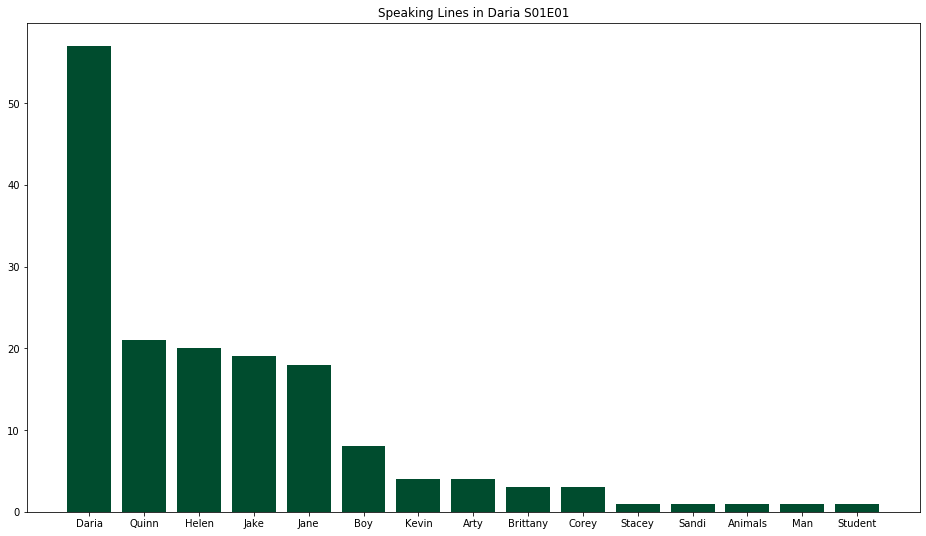

In [206]:
plt.figure(figsize = (16,9))
plt.bar(x = df_speaking_lines['person'], height = df_speaking_lines['lines'], color = '#004C2E')
plt.title('Speaking Lines in Daria S01E01')